In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [145]:
class Pair_trading():
    def __init__(self, data_var,data_preco, par, valor_inicial):
        self.financeiro = valor_inicial
        self.posicionado = 0 #comeca sem nenhuma operação aberta
        self.lista_resultado_operacoes = []
        self.lista_evolucao_carteira = []
        self.lista_dias_carregando = []
        self.lista_rentabilidade_operacao = []
        self.contador_dias = 0 
        self.perm_pct_acumulado = 1
        #guarda tickers das acoes
        self.t1 = par[0] 
        self.t2 = par[1]
        self.volume_operacao = 0

        self.dados_var = data_var
        self.dados_preco = data_preco

    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs
        
    def condicoes_operar(self,zs, gatilho_high, preco_s1, preco_s2, index):
        if zs >= gatilho_high and self.posicionado == 0:
            #parametros para iniciar operacao
            self.posicionado = 1 #entrou em uma operacao            
            self.volume = (self.financeiro/2)//preco_s1
            self.razao = preco_s1/preco_s2
            self.contador_dias = index
            #guarda dados de quantas ações está comprado/vendido
            self.qtd_s1 =  self.volume
            self.qtd_s2 =  self.volume*self.razao
            #calcula valor total da compra e venda (idealmente devem ser iguais)
            valor_operado_s1 =  preco_s1*self.qtd_s1 #vende  s1 (credita caixa)
            valor_operado_s2 = -preco_s2*self.qtd_s2 #compra s2 (debita caixa) 
#             print(f'v1  R${valor_operado_s1:.2f} | v2 R${valor_operado_s2:.2f}')
#             print(f'C1  R${preco_s1:.2f} | D2 R${(preco_s2*self.razao):.2f}')
            self.financeiro += valor_operado_s1 + valor_operado_s2

        elif zs <= 0.08 and self.posicionado == 1:
            #calcula preço das açoes que estão em carteira
            valor_operado_s1 = -self.qtd_s1*preco_s1 #compra s1 (debita  caixa) 
            valor_operado_s2 =  self.qtd_s2*preco_s2 #vende  s2 (credita caixa)
#             print(f'v1 R${valor_operado_s1:.2f} | v2  R${valor_operado_s2:.2f}')
#             print(f'D1  R${preco_s1:.2f} | C2 R${(preco_s2*self.razao):.2f}')
            resultado_trade = valor_operado_s1 + valor_operado_s2 
#             print(f'resu: R${resultado_trade:.2f}\n')
            self.financeiro += resultado_trade 
            #zera quantidades de ações sendo operadas
            self.qtd_s1 -= self.qtd_s1
            self.qtd_s2 -= self.qtd_s2
            #guarda dados para acompanhamento ao longo do tempo
            pct_change_trade = resultado_trade/(self.financeiro-resultado_trade)
            self.perm_pct_acumulado = self.perm_pct_acumulado*(1+pct_change_trade)
            self.lista_rentabilidade_operacao.append(pct_change_trade*100)
            self.lista_evolucao_carteira.append(self.financeiro)
            self.lista_dias_carregando.append(index-self.contador_dias)
            self.lista_resultado_operacoes.append(resultado_trade)
            #zera parametros para próximas operações 
            self.posicionado = 0
            self.razao = 0
            self.volume = 0
            self.contador_dias = 0
        
    def opera(self):
        period = 45
        c = 0
        s1 = self.dados_var[self.t1]
        s2 = self.dados_var[self.t2]
        for index in range(period, len(self.dados_var)):
            j1 = (s1[c:index]) #seleciona a acao 1 com uma janela com *period* dias 
            j2 = (s2[c:index])

            preco_s1 = self.dados_preco[self.t1][self.dados_var.index == index].values[0]
            preco_s2 = self.dados_preco[self.t2][self.dados_var.index == index].values[0]
            
            zs = self.calcula_zscore_spread(stock1=j1,stock2=j2)
            self.condicoes_operar(zs=zs, gatilho_high = 1.1, preco_s1=preco_s1, preco_s2=preco_s2, index=index)
            c += 1

        

In [146]:
data = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/Relatório 1/dados_relatorio.xlsx')[1:]
data_var = data.drop('time',axis=1).pct_change()[1:600]
data_preco = data[1:600]

In [147]:
print(data.columns.tolist())

['time', 'close IBOV', 'close ABEV3', 'close AZUL4', 'close B3SA3', 'close BBAS3', 'close BBDC3', 'close BBDC4', 'close BBSE3', 'close BEEF3', 'close BPAC11', 'close BRAP4', 'close BRDT3', 'close BRFS3', 'close BRKM5', 'close BRML3', 'close BTOW3', 'close CCRO3', 'close CIEL3', 'close CMIG4', 'close COGN3', 'close CPFE3', 'close CRFB3', 'close CSAN3', 'close CSNA3', 'close CVCB3', 'close CYRE3', 'close ECOR3', 'close EGIE3', 'close ELET3', 'close ELET6', 'close EMBR3', 'close ENBR3', 'close ENGI11', 'close EQTL3', 'close FLRY3', 'close GGBR4', 'close GNDI3', 'close GOAU4', 'close GOLL4', 'close HAPV3', 'close HGTX3', 'close HYPE3', 'close IGTA3', 'close IRBR3', 'close ITSA4', 'close ITUB4', 'close JBSS3', 'close KLBN11', 'close LAME4', 'close LREN3', 'close MGLU3', 'close MRFG3', 'close MRVE3', 'close MULT3', 'close NTCO3', 'close PETR3', 'close PETR4', 'close QUAL3', 'close RADL3', 'close RAIL3', 'close RENT3', 'close SANB11', 'close SBSP3', 'close SULA11', 'close SUZB3', 'close TAEE1

In [184]:
tickers = [['close USIM5','close VALE3'],['close PETR4','close PETR3']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']

In [149]:
lista_pares_usados = []
dic = {}
for i in tickers:
    a = (i[0]+' x '+i[1])
    lista_pares_usados.append(a)
    dic[a] = Pair_trading(data_var=data_var, data_preco=data_preco, par=i, valor_inicial=1000)
    dic[a].opera()


In [150]:
for k,v in dic.items():
    print(k)

close USIM5 x close VALE3
close PETR4 x close PETR3


Valor final em carteira: R$3928.61
peformance acumulado 392.86% em 58 operações


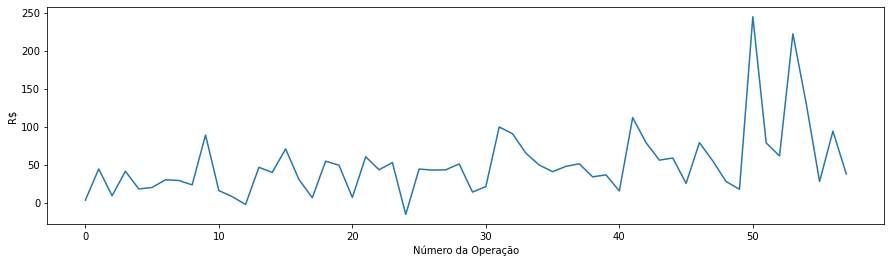

In [159]:
plt.figure(figsize=[15,4])
l1 = dic['close USIM5 x close VALE3'].lista_resultado_operacoes
l2 = dic['close USIM5 x close VALE3'].financeiro
l3 = dic['close USIM5 x close VALE3'].perm_pct_acumulado
print(f'Valor final em carteira: R${l2:.2f}')
print(f'peformance acumulado {l3*100:.2f}% em {len(l1)} operações')
plt.plot(l1)
plt.ylabel('R$')
plt.xlabel('Número da Operação')
plt.show()

In [161]:
print('Informações sobre o ganho em R$ das operações')
l1_series = pd.DataFrame(l1)
print(l1_series.describe())

Informações sobre o ganho em R$ das operações
                0
count   58.000000
mean    50.493302
std     45.416698
min    -15.518106
25%     23.861751
50%     43.227033
75%     59.980355
max    244.754899


In [132]:
for k,v in dic.items():
    lista_dias_series = pd.Series(v.lista_rentabilidade_operacao)
    print(k,lista_dias_series.describe(),'\n |||||||||||||||||||||||||||||||||||||||||||')  

close USIM5 x close VALE3 count    58.000000
mean      2.401325
std       1.728033
min      -0.867014
25%       1.107726
50%       2.173796
75%       3.026902
max       8.074431
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
close PETR4 x close PETR3 count    58.000000
mean      0.626325
std       0.646037
min       0.107551
25%       0.263175
50%       0.463736
75%       0.668954
max       3.861874
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||


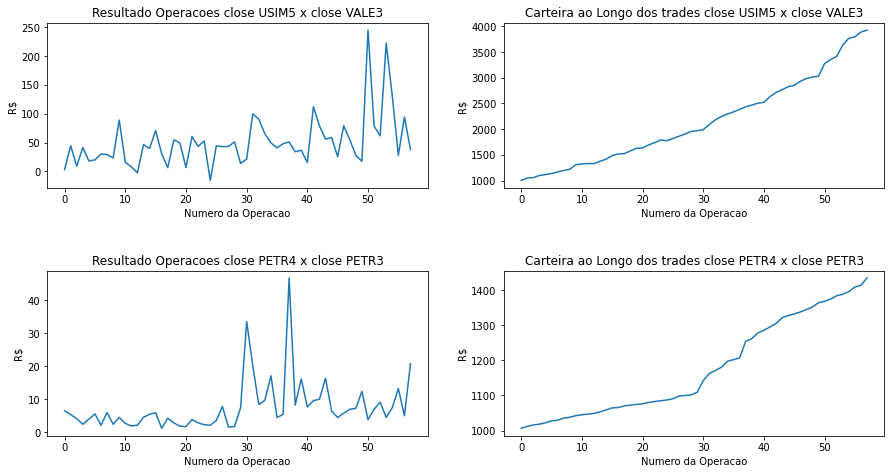

In [133]:
fig = plt.figure(figsize=(15, 30))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_resultado_operacoes)
    plt.title('Resultado Operacoes '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    
    contador1 += 1
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_evolucao_carteira)
    plt.title('Carteira ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')

    contador1 += 1
    
plt.show()

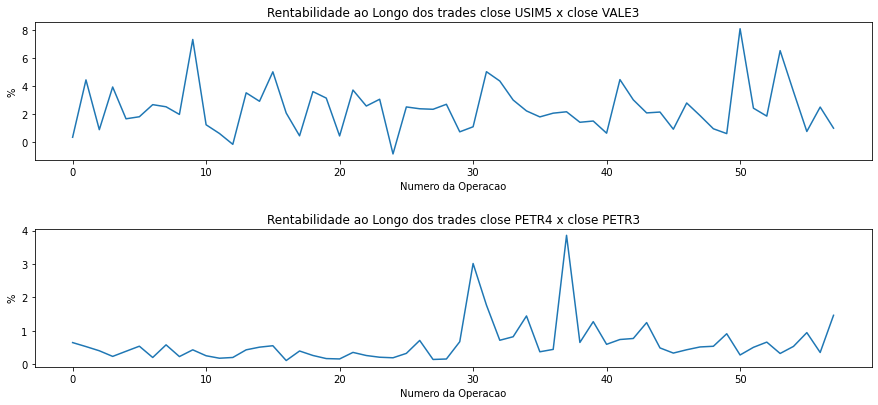

In [134]:
fig = plt.figure(figsize=(15, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
#     plt.subplot(8, 2, contador1)
#     plt.hist(dic[i].lista_dias_carregando, bins=8)
#     plt.title('Dias Posicionado '+ i)
#     plt.xlabel('Numero da Operacao')
#     plt.ylabel('R$')
#     contador1+=1

    plt.subplot(8, 1, contador1)
    plt.plot(dic[i].lista_rentabilidade_operacao)
    plt.title('Rentabilidade ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('%')

    contador1 += 1

plt.show()

## Testando com muitos pares, para escolher os melhores

In [124]:
lista_tickers = data.drop(['time','close IBOV'],axis=1)
lista_tickers = lista_tickers.columns.to_list()
print(lista_tickers)

['close ABEV3', 'close AZUL4', 'close B3SA3', 'close BBAS3', 'close BBDC3', 'close BBDC4', 'close BBSE3', 'close BEEF3', 'close BPAC11', 'close BRAP4', 'close BRDT3', 'close BRFS3', 'close BRKM5', 'close BRML3', 'close BTOW3', 'close CCRO3', 'close CIEL3', 'close CMIG4', 'close COGN3', 'close CPFE3', 'close CRFB3', 'close CSAN3', 'close CSNA3', 'close CVCB3', 'close CYRE3', 'close ECOR3', 'close EGIE3', 'close ELET3', 'close ELET6', 'close EMBR3', 'close ENBR3', 'close ENGI11', 'close EQTL3', 'close FLRY3', 'close GGBR4', 'close GNDI3', 'close GOAU4', 'close GOLL4', 'close HAPV3', 'close HGTX3', 'close HYPE3', 'close IGTA3', 'close IRBR3', 'close ITSA4', 'close ITUB4', 'close JBSS3', 'close KLBN11', 'close LAME4', 'close LREN3', 'close MGLU3', 'close MRFG3', 'close MRVE3', 'close MULT3', 'close NTCO3', 'close PETR3', 'close PETR4', 'close QUAL3', 'close RADL3', 'close RAIL3', 'close RENT3', 'close SANB11', 'close SBSP3', 'close SULA11', 'close SUZB3', 'close TAEE11', 'close TIMP3', 'cl

In [162]:
for i in range(len(lista_tickers)):
    for j in range(i,len(lista_tickers)):
        print(f'{lista_tickers[i]} X {lista_tickers[j]}')


close ABEV3 X close ABEV3
close ABEV3 X close AZUL4
close ABEV3 X close B3SA3
close ABEV3 X close BBAS3
close ABEV3 X close BBDC3
close ABEV3 X close BBDC4
close ABEV3 X close BBSE3
close ABEV3 X close BEEF3
close ABEV3 X close BPAC11
close ABEV3 X close BRAP4
close ABEV3 X close BRDT3
close ABEV3 X close BRFS3
close ABEV3 X close BRKM5
close ABEV3 X close BRML3
close ABEV3 X close BTOW3
close ABEV3 X close CCRO3
close ABEV3 X close CIEL3
close ABEV3 X close CMIG4
close ABEV3 X close COGN3
close ABEV3 X close CPFE3
close ABEV3 X close CRFB3
close ABEV3 X close CSAN3
close ABEV3 X close CSNA3
close ABEV3 X close CVCB3
close ABEV3 X close CYRE3
close ABEV3 X close ECOR3
close ABEV3 X close EGIE3
close ABEV3 X close ELET3
close ABEV3 X close ELET6
close ABEV3 X close EMBR3
close ABEV3 X close ENBR3
close ABEV3 X close ENGI11
close ABEV3 X close EQTL3
close ABEV3 X close FLRY3
close ABEV3 X close GGBR4
close ABEV3 X close GNDI3
close ABEV3 X close GOAU4
close ABEV3 X close GOLL4
close ABEV

In [113]:
data[['time','close IBOV']][:1481]

,time,close IBOV
1,2012-01-04,59365
2,2012-01-05,58546
3,2012-01-06,58600
4,2012-01-09,59083
5,2012-01-10,59806
...,...,...
1477,2017-12-21,75133
1478,2017-12-22,75187
1479,2017-12-26,75708
1480,2017-12-27,76073


In [165]:
data_teste_todos = data.drop(['time','close IBOV'],axis=1)
data_teste_todos = data_teste_todos[1000:1481]
data_var_tt = data_teste_todos.pct_change()[1:]
data_preco_tt = data_teste_todos[1:]

In [167]:
data_preco_tt

,close ABEV3,close AZUL4,close B3SA3,close BBAS3,close BBDC3,close BBDC4,close BBSE3,close BEEF3,close BPAC11,close BRAP4,...,close TAEE11,close TIMP3,close TOTS3,close UGPA3,close USIM5,close VALE3,close VIVT4,close VVAR3,close WEGE3,close YDUQ3
1002,15.07,NaN,8.89,10.87,8.97,8.28,14.47,11.23,NaN,2.71,...,10.28,5.42,9.06,24.80,0.92,8.09,25.21,1.11,10.10,8.43
1003,15.94,NaN,9.17,10.71,9.15,8.38,14.51,11.38,NaN,2.80,...,10.77,5.72,9.22,25.61,0.86,8.51,26.04,1.11,10.51,8.49
1004,16.01,NaN,9.26,10.95,9.31,8.39,14.98,11.58,NaN,2.71,...,10.98,5.49,9.42,25.82,0.82,8.44,25.62,1.23,10.48,8.39
1005,16.70,NaN,9.17,11.68,9.50,8.75,15.93,11.94,NaN,2.87,...,11.37,5.78,10.12,26.60,0.81,8.79,26.24,1.22,11.00,9.23
1006,16.57,NaN,9.35,11.94,9.61,8.98,16.19,11.91,NaN,2.92,...,11.59,5.83,10.01,26.20,0.91,8.59,25.96,1.32,10.73,9.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,19.90,26.49,20.62,28.14,19.42,20.98,21.97,10.37,17.49,25.66,...,16.48,12.12,9.84,34.77,8.79,37.14,40.68,7.69,17.97,31.01
1478,19.96,26.49,20.84,28.24,19.53,21.04,21.94,10.31,17.23,26.01,...,16.66,11.99,9.80,34.74,8.69,37.54,40.36,7.73,18.02,30.92
1479,20.17,26.44,20.90,28.54,19.69,21.00,21.90,10.39,17.19,26.11,...,16.91,12.06,9.84,34.68,8.73,37.59,40.80,7.80,18.34,31.00
1480,20.31,26.33,21.19,28.89,19.82,21.03,22.08,10.77,17.23,26.25,...,16.88,12.16,9.76,34.82,8.84,37.60,40.73,7.84,18.33,30.72


In [181]:
l_tickers_tt = []
for i in range(len(lista_tickers)):
    for j in range(i,len(lista_tickers)):
#         print(f'{lista_tickers[i]} X {lista_tickers[j]}')
        if i == 44:
            l_tickers_tt.append([lista_tickers[i],lista_tickers[j]])

In [183]:
for i in l_tickers_tt:
    print(i)

['close ITUB4', 'close ITUB4']
['close ITUB4', 'close JBSS3']
['close ITUB4', 'close KLBN11']
['close ITUB4', 'close LAME4']
['close ITUB4', 'close LREN3']
['close ITUB4', 'close MGLU3']
['close ITUB4', 'close MRFG3']
['close ITUB4', 'close MRVE3']
['close ITUB4', 'close MULT3']
['close ITUB4', 'close NTCO3']
['close ITUB4', 'close PETR3']
['close ITUB4', 'close PETR4']
['close ITUB4', 'close QUAL3']
['close ITUB4', 'close RADL3']
['close ITUB4', 'close RAIL3']
['close ITUB4', 'close RENT3']
['close ITUB4', 'close SANB11']
['close ITUB4', 'close SBSP3']
['close ITUB4', 'close SULA11']
['close ITUB4', 'close SUZB3']
['close ITUB4', 'close TAEE11']
['close ITUB4', 'close TIMP3']
['close ITUB4', 'close TOTS3']
['close ITUB4', 'close UGPA3']
['close ITUB4', 'close USIM5']
['close ITUB4', 'close VALE3']
['close ITUB4', 'close VIVT4']
['close ITUB4', 'close VVAR3']
['close ITUB4', 'close WEGE3']
['close ITUB4', 'close YDUQ3']


In [187]:
l_usados_tickers = []
dic = {}
for i in l_tickers_tt:
    a = (i[0]+' x '+i[1])
    l_usados_tickers.append(a)
    dic[a] = Pair_trading(data_var=data_var, data_preco=data_preco, par=i, valor_inicial=1000)
    dic[a].opera()

<ipython-input-145-bacfedbbc313>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.volume = (self.financeiro/2)//preco_s1


In [188]:
dic

{'close ITUB4 x close ITUB4': <__main__.Pair_trading at 0x7fbacf34f340>,
 'close ITUB4 x close JBSS3': <__main__.Pair_trading at 0x7fbacf4e2880>,
 'close ITUB4 x close KLBN11': <__main__.Pair_trading at 0x7fbacc8f31c0>,
 'close ITUB4 x close LAME4': <__main__.Pair_trading at 0x7fbaf0776fa0>,
 'close ITUB4 x close LREN3': <__main__.Pair_trading at 0x7fbad03088b0>,
 'close ITUB4 x close MGLU3': <__main__.Pair_trading at 0x7fbacf34f580>,
 'close ITUB4 x close MRFG3': <__main__.Pair_trading at 0x7fbad002c100>,
 'close ITUB4 x close MRVE3': <__main__.Pair_trading at 0x7fbacf4e4eb0>,
 'close ITUB4 x close MULT3': <__main__.Pair_trading at 0x7fbad05fd880>,
 'close ITUB4 x close NTCO3': <__main__.Pair_trading at 0x7fbacc8fec70>,
 'close ITUB4 x close PETR3': <__main__.Pair_trading at 0x7fbacf4d2e80>,
 'close ITUB4 x close PETR4': <__main__.Pair_trading at 0x7fbad00049a0>,
 'close ITUB4 x close QUAL3': <__main__.Pair_trading at 0x7fbad0015d30>,
 'close ITUB4 x close RADL3': <__main__.Pair_tradi

In [193]:
# fig = plt.figure(figsize=(15, 30))
# plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
# contador1 = 1
lista_rentabilidades = []
for i in l_usados_tickers:
#     print(f'{i} : {dic[i].perm_pct_acumulado:.2f}')
    lista_rentabilidades.append(dic[i].perm_pct_acumulado)


In [198]:
print(sorted(lista_rentabilidades))

[1.0, 1.0401848392199744, 1.9779974608451347, 2.113795162940168, 2.2199668943288664, 2.324787241584354, 2.4328817441476676, 2.4395403947565124, 2.550764145483682, 2.600587488717594, 2.695171593298241, 2.7267970682422527, 2.9234950929048926, 3.015577138494651, 3.0326977892172535, 3.0866631267512106, 3.122994068986276, 3.3187614936016003, 3.424196718234306, 3.439846198898594, 3.4698984523578273, 3.49789592536467, 3.504695164521303, 3.903577232833669, 5.5262701390354065, 5.687655149306515, 6.1082167214243075, 7.220161817206501, 7.552319209782081, nan]


In [204]:
for i in lista_rentabilidades:
    for k,v in dic.items():
        if v.perm_pct_acumulado == i:
            print(f'{k} {i:.2f}')

close ITUB4 x close ITUB4 1.00
close ITUB4 x close KLBN11 1.04
close ITUB4 x close TAEE11 1.98
close ITUB4 x close VIVT4 2.11
close ITUB4 x close SANB11 2.22
close ITUB4 x close MULT3 2.32
close ITUB4 x close UGPA3 2.43
close ITUB4 x close RENT3 2.44
close ITUB4 x close WEGE3 2.55
close ITUB4 x close LAME4 2.60
close ITUB4 x close SBSP3 2.70
close ITUB4 x close LREN3 2.73
close ITUB4 x close TOTS3 2.92
close ITUB4 x close SULA11 3.02
close ITUB4 x close NTCO3 3.03
close ITUB4 x close VALE3 3.09
close ITUB4 x close QUAL3 3.12
close ITUB4 x close YDUQ3 3.32
close ITUB4 x close PETR4 3.42
close ITUB4 x close RAIL3 3.44
close ITUB4 x close RADL3 3.47
close ITUB4 x close TIMP3 3.50
close ITUB4 x close PETR3 3.50
close ITUB4 x close SUZB3 3.90
close ITUB4 x close JBSS3 5.53
close ITUB4 x close USIM5 5.69
close ITUB4 x close MRVE3 6.11
close ITUB4 x close MGLU3 7.22
close ITUB4 x close MRFG3 7.55
